# Sentiment Analysis: Part 2

## ECE 590 Homework assignment 3

Name: Javier Cervantes

net id: jc1010

In this part of the assignment, we shall try and understand what the model for HW2 is doing. 

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [3]:
seed = 257

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [4]:
class Sentiment(nn.Module):
    def __init__(self, vocab_size, embed_dim, pad_index):
        super(Sentiment, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_index)
        self.fc = nn.Linear(embed_dim, 2)

    def forward(self, x):
        x = self.embedding(x)
        x = x.mean(dim=1)
        x = torch.sigmoid(x)
        x = self.fc(x)

        return x

In [5]:
with open("../models/words500_vocab.pkl", "rb") as f:
    vocab = pickle.load(f)

In [6]:
vocab_size = len(vocab)
embed_dim = 50
pad_index = vocab["<pad>"]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = Sentiment(vocab_size, embed_dim, pad_index)
model.load_state_dict(torch.load("../models/emb50_words500.pt"))
model = model.to(device)

cuda


In [7]:
# add embeddings to vocab
embeddings = model.embedding.weight.detach().cpu().numpy()
word_to_embedding = {word: embeddings[i] for word, i in vocab.get_stoi().items()}

### Question 1

We expect to find most of the values within each dimension of our word embeddings to be close to zero. The motivation behind this hypothesis is that sentiment presumably has fewer features required to understand it. This would imply that a few dimensions will have a wider range of values while the rest will be close to zero.

To provide insights into this hypothesis, I'll plot a boxplot for each dimension of my word embeddings.

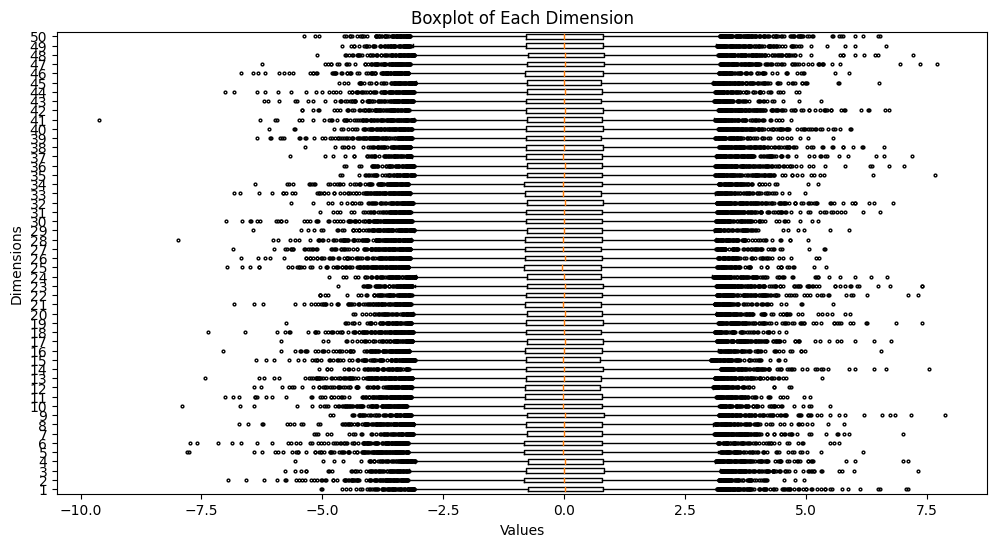

In [8]:
# Create the plot
plt.figure(figsize=(12, 6))
plt.boxplot(embeddings, vert=False, flierprops=dict(marker="o", markersize=2))
plt.xlabel("Values")
plt.ylabel("Dimensions")
plt.title("Boxplot of Each Dimension")
plt.show()

> While there are certainly a few dimensions that have a wider range of values, the sparsity I was expecting is not present. I interpret these results as "sentiment" being a bit more complex than I initially thought. Having said that, we can see that the IQR for each embedding is quite small and centered around zero. This would suggest that most words are meaningless for sentiment analysis. Another interesting insight is that each dimension seems to have either a significant rightward or leftward skew.

### Question 2

Now let's explore the words with the largest values in the dimensions that show the most variance. 

In [9]:
# extract the 10 most postive and negative words for each of the 10 dimensions with the highest variance
variances = np.var(embeddings, axis=0)
highest_variance_dims = np.argsort(variances)[-10:]

for dimension in highest_variance_dims:
    # get the 10 words with the highest and lowest values for this dimension
    negative_words = [
        vocab.get_itos()[word] for word in np.argsort(embeddings[:, dimension])[:10]
    ]
    positive_words = [
        vocab.get_itos()[word] for word in np.argsort(embeddings[:, dimension])[-10:]
    ]
    print(f"Dimension {dimension}")
    print(f"Negative words: {negative_words}")
    print(f"Positive words: {positive_words}")

Dimension 12
Negative words: ['worst', 'poisoning', 'bland', 'terrible', 'disgusting', 'acknowledge', 'boring', 'stale', 'watered', 'poorly']
Positive words: ['grilled', 'solid', 'amazing', 'located', 'luscious', 'enjoyed', 'incredible', 'reasonable', 'komex', 'pleasantly']
Dimension 13
Negative words: ['delicious', 'beat', 'exceeded', 'perfection', 'definitely', 'gem', 'thorough', 'yum', 'devoured', 'perfect']
Positive words: ['unprofessional', 'downhill', 'nasty', 'overkill', 'horrible', 'flavorless', 'poorly', 'mediocre', 'terrible', 'worst']
Dimension 2
Negative words: ['glad', 'outstanding', 'exceeded', 'pleasantly', 'delicious', 'gem', 'excellent', 'phenomenal', 'bonus', 'impeccable']
Positive words: ['bugs', 'substandard', 'disappointment', 'advertise', 'tasteless', 'unacceptable', 'meh', 'disappointing', 'horrible', 'worst']
Dimension 45
Negative words: ['worst', 'unfriendly', 'meh', 'mediocre', 'disappointing', 'awful', 'worse', 'terrible', 'poorly', 'overrated']
Positive word

Dimension 5
Negative words: ['mediocre', 'worst', 'terrible', 'disappointing', 'overpriced', 'horrible', 'bland', 'lacking', 'rude', 'unprofessional']
Positive words: ['cutest', 'gem', 'incredible', 'yum', 'best', 'notch', 'bomb', 'fantastic', 'delicious', 'excellent']
Dimension 9
Negative words: ['horrible', 'worst', 'downhill', 'ridiculous', 'flavorless', 'excited', 'poisoning', 'meh', 'causing', 'unimpressive']
Positive words: ['drawback', 'yum', 'impeccable', 'glad', 'bomb', 'magnificent', 'yummy', 'delicious', 'loved', 'coolest']
Dimension 4
Negative words: ['bland', 'worst', 'undercooked', 'poorly', 'overrated', 'lacked', 'disgusting', 'disappointing', 'underwhelming', 'awful']
Positive words: ['reasonable', 'drawback', 'delicious', 'deliciousness', 'amazing', 'happier', 'favorite', 'glad', 'phenomenal', 'pleasantly']
Dimension 49
Negative words: ['addicted', 'disappoint', 'gem', 'hooked', 'superb', 'yum', 'perfect', 'gentle', 'pinto', 'haters']
Positive words: ['tasteless', 'bur

>It's hard to assign a "category" to any single dimension. Every dimension seems to include words related to food like "undercooked", "tasteless" or "delicious". Additionally, some dimensions contain the same words but with different polarities. For example, "disappointing" appears as a negative word in dimension 45 and appears as a positive word in dimension 49. The sentiment in dimension 13 seems to be flipped, where all of the negative words are intuitively positive and vice versa.

### Question 3

Examining the weight vector, $w$, from the logistic regression: we want to examine whether $w$ is sparse. Then, we shall pick the component of $w$ that is most positive and that which is most negative. Then, we'll examine the learned word embeddings to identify the words that have large values in that dimension.

In [10]:
# extracting the weight vector from the logistic regression
weights = model.fc.weight.detach().cpu().numpy().squeeze()
print(weights)

[[ 0.9697665  -0.9535457   1.0558232   1.0459803  -1.1449919  -0.9722121
   0.9885289  -1.0241486   1.100456   -1.1085787  -0.93821985 -0.942131
  -1.0195959   0.95734364 -1.0357935  -0.797732    0.97717386 -0.8384108
   0.8705606   0.9257118  -0.9070528   0.8486651   0.9231779   0.9885017
  -1.0476626  -1.0765103  -0.889703   -0.989791   -0.9768179  -1.1043869
   1.0011213   1.0243168  -0.9995889  -0.98195827  0.84616804  0.9827963
   0.87704915  0.96786255 -0.92599636  0.92851776 -1.0020884   0.8166731
  -1.0855615  -1.0133613   0.90544516 -0.9746938   1.0138685   1.0208315
   0.9365853   1.0717332 ]
 [-1.0804967   1.0647209  -0.9906733  -0.941758    0.93840796  1.1341406
  -0.8437965   0.96239775 -0.88430053  0.86327934  0.8673959   0.7879985
   0.7762734  -1.0433383   0.95828307  1.059785   -1.0516129   0.9837181
  -0.9829849  -0.863728    1.0324633  -1.0513674  -1.0654879  -0.9848942
   1.1086998   0.9052855   1.0298259   0.99543583  0.89210844  1.0128409
  -0.99070865 -0.96406525

>As we can see, the weight vector is not sparse. There are very few values around zero. Most are centered either around 1 or -1. What is intuitive is the fact that the weight vector for label 0 has the opposite signs of the weight vector for label 1. This is true for each dimension.

In [11]:
# most positive dimension
pos_dim = int(np.argsort(weights[1])[-1:])
# most negative dimension
neg_dim = int(np.argsort(weights[0])[-1:])

In [12]:
# words with the highest values for the most positive dimension
positive_words = [
    vocab.get_itos()[word] for word in np.argsort(embeddings[:, pos_dim])[-10:]
]

# words with the highest values for the most negative dimension
negative_words = [
    vocab.get_itos()[word] for word in np.argsort(embeddings[:, neg_dim])[-10:]
]

print(f"Positive words: {positive_words}")
print(f"Negative words: {negative_words}")

Positive words: ['cutest', 'gem', 'incredible', 'yum', 'best', 'notch', 'bomb', 'fantastic', 'delicious', 'excellent']
Negative words: ['dirty', 'disgusting', 'wilted', 'terrible', 'horrible', 'stale', 'inedible', 'meh', 'disappointment', 'worst']


> I would interpret each one of the words above as words containing "high sentimental value". This suggests that what the model is doing is quite intuitive: it's assigning high weights to dimensions that have correctly identified words with high sentimental value.

### Question 4

We want to examine the bias within the learned logistic regression model.

In [15]:
# extract the bias term
bias = model.fc.bias.detach().cpu().numpy().squeeze()
print(f"Bias: {bias}")

Bias: [0.05773593 0.07802495]


>The bias term suggests that the model is awarding a slight edge to the positive class. This would suggest that, absent strong sentimental words, the model would lean towards predicting a document as positive. The difference is marginal which leads me to conclude that the dataset is quite balanced between classes.